In [1]:
# imports and set up plots
using Distributions
using LinearAlgebra: diag
using Random
using GaussianProcesses
import Statistics

import PyPlot; plt=PyPlot
using LaTeXStrings
cbbPalette = ["#E69F00", "#56B4E9", "#009E73",
                "#F0E442", "#0072B2", "#D55E00",
                "#CC79A7"];

In [2]:
""" The true function we will be simulating from. """
function fstar(x::Float64)
    return abs(x-5)*cos(2*x)
end

σy = 1.0
n=5000

Random.seed!(1) # for reproducibility
Xdistr = Beta(7,7)
ϵdistr = Normal(0,σy)
x = rand(Xdistr, n)*10
X = Matrix(x')
Y = fstar.(x) .+ rand(ϵdistr,n)
;

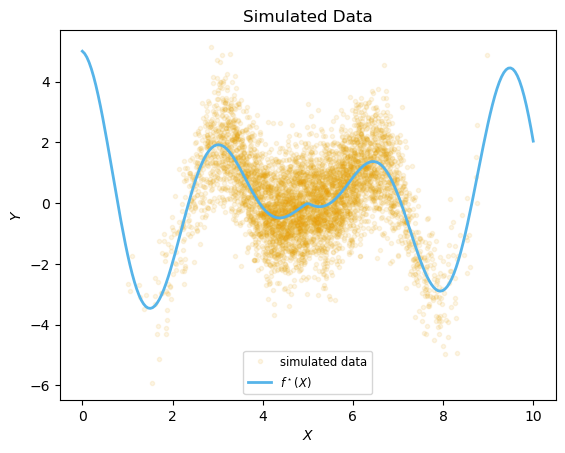

In [3]:
xx = range(0, stop=10, length=200)
plt.plot(x, Y, ".", color=cbbPalette[1], label="simulated data", alpha=0.1)
plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
plt.xlabel(L"X")
plt.ylabel(L"Y")
plt.title("Simulated Data")
plt.legend(loc="lower center", fontsize="small")
;

In [4]:
k = SEIso(log(0.3), log(5.0))
GP(X, Y, MeanZero(), k, log(σy)) # warm-up
# time the second run (so the time doesn't include compilation):
@time gp_full = GP(X, Y,  MeanZero(), k, log(σy))

  0.739635 seconds (22 allocations: 572.320 MiB, 25.31% gc time)


GP Exact object:
  Dim = 1
  Number of observations = 5000
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SEIso{Float64}, Params: [-1.2039728043259361, 1.6094379124341003]
  Input observations = 
[4.921764165378995 5.275309754553822 … 3.4800203151003806 5.436037074860794]
  Output observations = [-1.9926288041923799, -0.7137458188018238, 0.8760872841469849, 1.1457949273077903, -1.5061007104877793, 1.6842944346266588, 0.443491134390653, -0.4076419693465955, -0.07588566059830401, 1.1655222401405976  …  0.5386953820053115, 2.618310675626291, -0.6286199935592225, -0.947587019156843, 0.5461248061067958, 0.4231529807986819, -0.2531204205138615, 1.8257398701322527, 2.298697411224885, 1.0842053303118755]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -7186.593

In [5]:
# extract predictions
predict_f(gp_full, xx; full_cov=true) # warm-up
@time μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
;

  0.070652 seconds (59 allocations: 15.878 MiB)


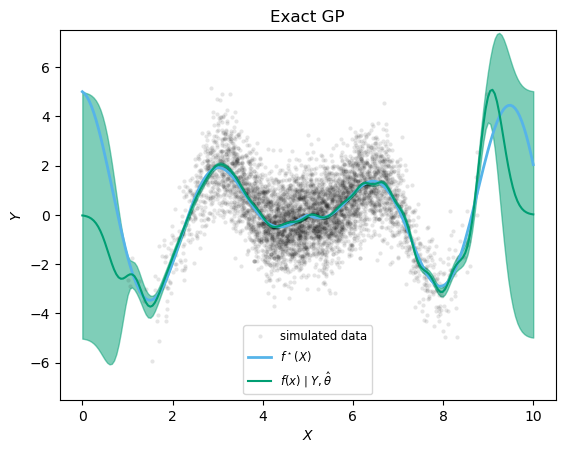

In [6]:
xx = range(0, stop=10, length=200)
plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
plt.plot(xx, μ_exact, color=cbbPalette[3], label=L"$f(x) \mid Y, \hat\theta$")
plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)),
                 color=cbbPalette[3], alpha=0.5)
plt.xlabel(L"X")
plt.ylabel(L"Y")
plt.title("Exact GP")
plt.legend(loc="lower center", fontsize="small")
plt.ylim(-7.5,7.5)
;

In [7]:
Xu = Matrix(quantile(x, [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.98])')

1×12 Array{Float64,2}:
 3.82567  4.06404  4.25939  4.4478  …  5.33994  5.53788  5.73281  7.64571

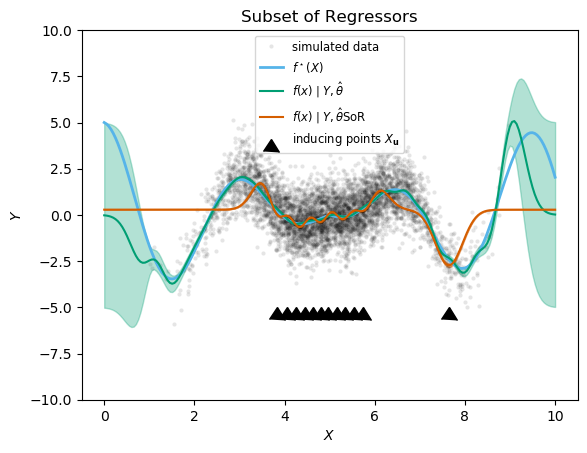

  0.001878 seconds (45 allocations: 2.032 MiB)


PyObject Text(0.5, 1, 'Subset of Regressors')

In [8]:
function plot_approximation(gp_exact, gp_approx, approx_label)
    μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
    μapprox, Σapprox = predict_f(gp_approx, xx; full_cov=true)
    plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
    plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
    plt.plot(xx, μ_exact, color=cbbPalette[3], label=L"$f(x) \mid Y, \hat\theta$")
    plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)),
                     color=cbbPalette[3], alpha=0.3)
    plt.plot(xx, μapprox, color=cbbPalette[6], label=L"$f(x) \mid Y, \hat\theta$"*approx_label)
    y_err = sqrt.(diag(Σapprox))
    plt.fill_between(xx, μapprox.-y_err, μapprox.+y_err,
                     color=cbbPalette[6], alpha=0.5)
    plt.xlabel(L"X")
    plt.ylabel(L"Y")
    plt.plot(vec(Xu), fill(0.0, length(Xu)).-5, linestyle="None",
        marker=6, markersize=12, color="black", label=L"inducing points $X_\mathbf{u}$")
    plt.legend(loc="upper center", fontsize="small")
    plt.ylim(-10, 10)
end

# SoR Method

gp_SOR = GaussianProcesses.SoR(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_SOR = GaussianProcesses.SoR(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

plot_approximation(gp_full, gp_SOR, "SoR")
plt.title("Subset of Regressors")

  0.001916 seconds (45 allocations: 2.032 MiB)


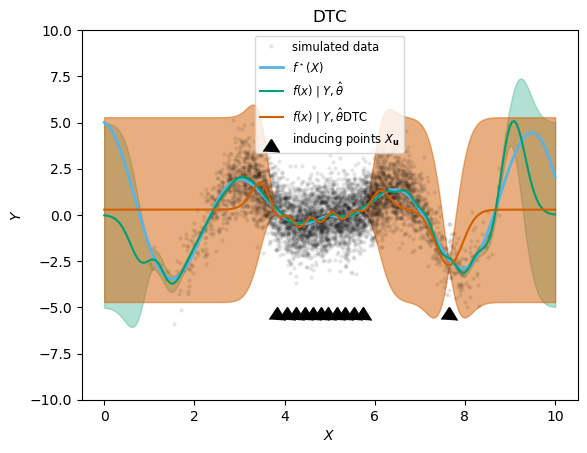

  0.001217 seconds (37 allocations: 2.063 MiB)


In [9]:
# DTC Method

gp_DTC = GaussianProcesses.DTC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_DTC = GaussianProcesses.DTC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

predict_f(gp_DTC, xx; full_cov=true)
@time predict_f(gp_DTC, xx; full_cov=true);

plot_approximation(gp_full, gp_DTC, "DTC")
plt.title("DTC")
;

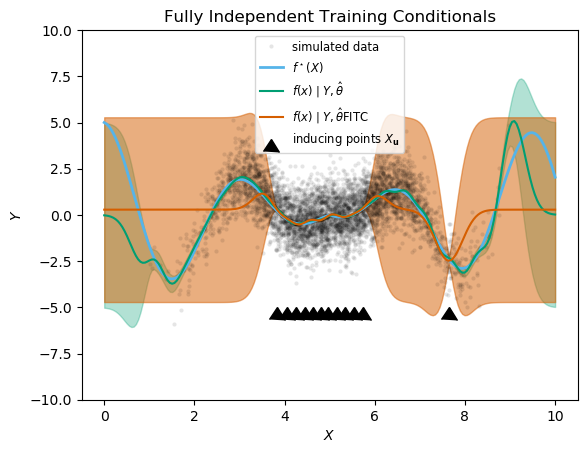

  0.005415 seconds (15.06 k allocations: 10.310 MiB)


PyObject Text(0.5, 1, 'Fully Independent Training Conditionals')

In [10]:
# FITC Method

gp_FITC = GaussianProcesses.FITC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_FITC = GaussianProcesses.FITC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

plot_approximation(gp_full, gp_FITC, "FITC")
plt.title("Fully Independent Training Conditionals")

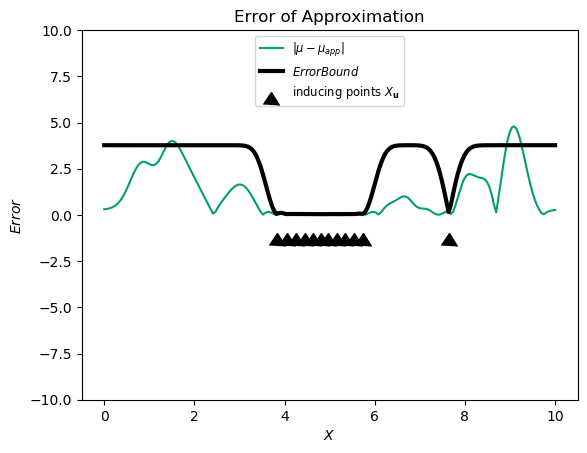

PyObject Text(0.5, 1, 'Error of Approximation')

In [11]:
## Error Plot using KL Divergence.

function mean_bound(σ1; γ=1/6)
    return σ1*sqrt(γ)/(sqrt(1-sqrt(3*γ)))
end

function plot_approximation_error(gp_exact, gp_approx, approx_label)
    μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
    μapprox, Σapprox = predict_f(gp_approx, xx; full_cov=false)
    
    err_bds = mean_bound.(sqrt.(Σapprox))
    
#     plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
#     plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
    plt.plot(xx, abs.(μ_exact-μapprox), color=cbbPalette[3], label=L"$|μ-μ_{app}|$")
    
    plt.plot(xx, err_bds, color=:black, linewidth=3, label=L"Error Bound")
    
#     plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)),
#                      color=cbbPalette[3], alpha=0.3)
#     plt.plot(xx, μapprox, color=cbbPalette[6], label=L"$f(x) \mid Y, \hat\theta$"*approx_label)
#     y_err = sqrt.(diag(Σapprox))
#     plt.fill_between(xx, μapprox.-y_err, μapprox.+y_err,
#                      color=cbbPalette[6], alpha=0.5)
    plt.xlabel(L"X")
    plt.ylabel(L"Error")
    plt.plot(vec(Xu), fill(0.0, length(Xu)).-1, linestyle="None",
        marker=6, markersize=12, color="black", label=L"inducing points $X_\mathbf{u}$")
    plt.legend(loc="upper center", fontsize="small")
    plt.ylim(-10, 10)
end

plot_approximation_error(gp_full, gp_FITC, "FITC")
plt.title("Error of Approximation")